In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')

In [2]:
# Import useful libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from collections import defaultdict

import matplotlib as mpl
import seaborn as sns

sns.set(style ='white',font_scale=1.25)

%matplotlib inline

In [3]:
with open('../data/01-House-Price/processed_data.pkl','rb') as file:
    train,y,test,FEATURES = pickle.load(file)

## **Building ML model**

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1017, 413)
X_test : (437, 413)
y_train : (1017,)
y_test : (437,)


# **Feature Standardizing**
- Perform standardization on all features except those one hot encoded.

In [5]:
FEATURES.keys()

dict_keys(['cat', 'num', 'aug_num', 'eng_num', 'ord_num', 'onehot_cat', 'interactions', 'interactions_num'])

In [6]:
feat_to_norm = FEATURES['num'] + FEATURES['aug_num'] + FEATURES['eng_num'] + FEATURES['ord_num'] + FEATURES['interactions_num']
print('Total %i features to normalize' %(len(feat_to_norm)))

Total 193 features to normalize


In [7]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train[feat_to_norm])

X_num_train_norm = pd.DataFrame(ss.transform(X_train[feat_to_norm]),columns=feat_to_norm,index=X_train.index)
X_cat_train = X_train[[col for col in X_train.columns if col not in feat_to_norm]]
X_train_preproc = pd.concat([X_num_train_norm,X_cat_train],axis=1)

X_num_test_norm = pd.DataFrame(ss.transform(X_test[feat_to_norm]),columns=feat_to_norm,index=X_test.index)
X_cat_test = X_test[[col for col in X_test.columns if col not in feat_to_norm]]
X_test_preproc = pd.concat([X_num_test_norm,X_cat_test],axis=1)

print("X_train_preproc : " + str(X_train_preproc.shape))
print("X_test_preproc : " + str(X_test_preproc.shape))

X_train_preproc : (1017, 413)
X_test_preproc : (437, 413)


In [8]:
from collections import namedtuple

models = namedtuple('models',['name','params',
                              'cv5_mean_train_rmse','cv5_std_train_rmse',
                              'cv5_mean_test_rmse','cv5_std_test_rmse'])
model_list = []

## **Linear Regression**

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score

In [10]:
def cv_rmse(mod,X,y,cv=5):
    scores = cross_val_score(mod,X,y,scoring="neg_mean_squared_error",cv=cv)
    return np.sqrt(-scores)

In [11]:
lr = LinearRegression()
lr.fit(X_train_preproc,y_train)


y_train_pred = lr.predict(X_train_preproc)
y_test_pred = lr.predict(X_test_preproc)

print('Train R-sq:',r2_score(y_train,y_train_pred))
print('Test R-sq:',r2_score(y_test,y_test_pred))

Train R-sq: 0.961951325302397
Test R-sq: 0.13563693286772205


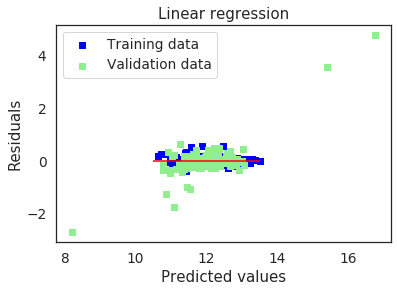

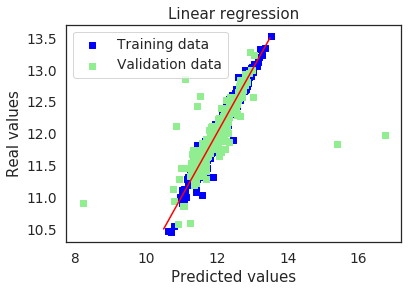

In [12]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")

In [13]:
cv5_train_rmse =  cv_rmse(lr, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(lr, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='LR',params=lr.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.19547239 0.22260698 2.89265961 4.70451832 0.20704471]
---------------------------------------------------------------------------
cv5 test rmse: [ 6.92663989  9.43531696 10.04495106  7.43494042  0.75766678]


## **Linear Regression with Ridge regularization (L2 penatly)**

In [14]:
from sklearn.linear_model import RidgeCV, Ridge

ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train_preproc, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 30.0


In [15]:
ridge = Ridge(alpha=1)
ridge.fit(X_train_preproc, y_train)
y_pred = ridge.predict(X_test_preproc)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.9049417639158248
MSE: 0.01431638170628522
RMSE: 0.11965108318057643
--------------------------------------------------
R-sq orig price: 0.9052294540945096
MSE orig price: 504588402.3935471
RMSE orig price: 22463.045260906794


In [16]:
ridge = Ridge(alpha=30)
ridge.fit(X_train_preproc, y_train)
y_pred = ridge.predict(X_test_preproc)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.9106963379568377
MSE: 0.013449705846076033
RMSE: 0.11597286685288087
--------------------------------------------------
R-sq orig price: 0.9115146702796537
MSE orig price: 471123920.75256723
RMSE orig price: 21705.389209884426


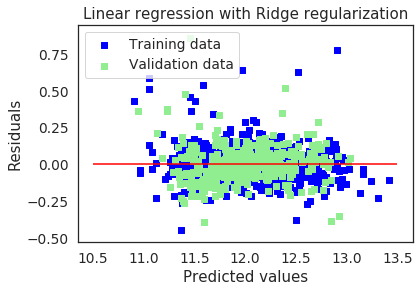

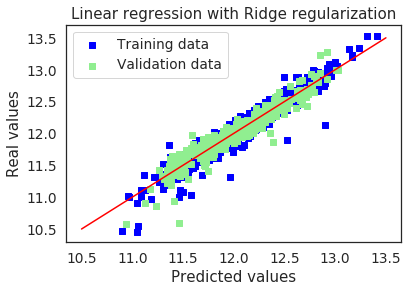

Ridge picked 401 features and eliminated the other 12 features


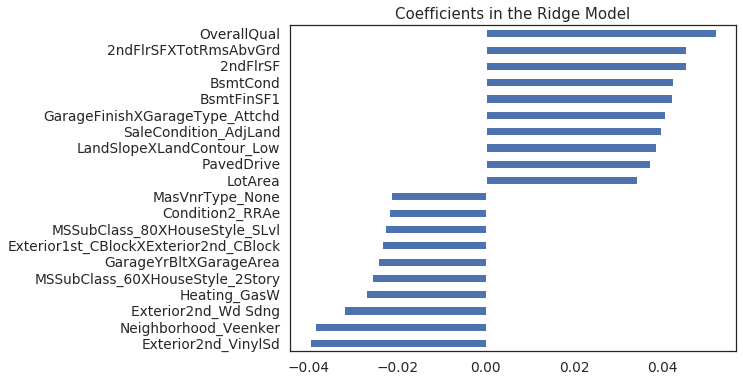

In [17]:
y_train_rdg = ridge.predict(X_train_preproc)
y_test_rdg = ridge.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Ridge Model");

In [18]:
cv5_train_rmse =  cv_rmse(ridge, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(ridge, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='ridge',params=ridge.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.13947973 0.15594796 0.11592563 0.12346708 0.103041  ]
---------------------------------------------------------------------------
cv5 test rmse: [0.12420195 0.12768577 0.14689902 0.10982712 0.10121051]


## **Linear Regression with Lasso regularization (L1 penalty)**

In [19]:
from sklearn.linear_model import LassoCV, Lasso

In [20]:
lasso = Lasso(alpha=1)
lasso.fit(X_train_preproc, y_train)
y_pred = lasso.predict(X_test_preproc)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

R-sq: -0.010079098464402358
MSE: 0.15212440839267974
RMSE: 0.39003129155579264
--------------------------------------------------
R-sq orig price: -0.007748113294549386
MSE orig price: 5365570131.984954
RMSE orig price: 73250.0520954419


In [21]:
lasso = Lasso(alpha=0.0003)
lasso.fit(X_train_preproc, y_train)
y_pred = lasso.predict(X_test_preproc)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))


y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

R-sq: 0.9028468674270554
MSE: 0.01463188659048927
RMSE: 0.12096233542094527
--------------------------------------------------
R-sq orig price: 0.8985223778391749
MSE orig price: 540299000.6609253
RMSE orig price: 23244.332656820356


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5628792346342921, tolerance: 0.01648745737340829
  positive)


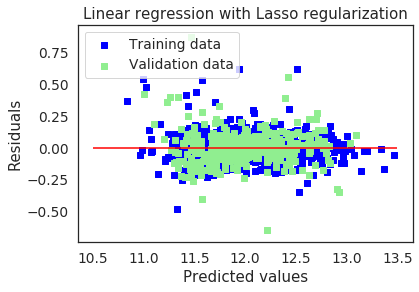

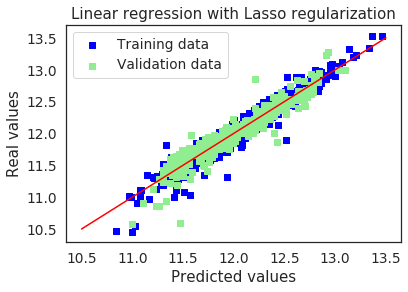

Lasso picked 169 features and eliminated the other 244 features


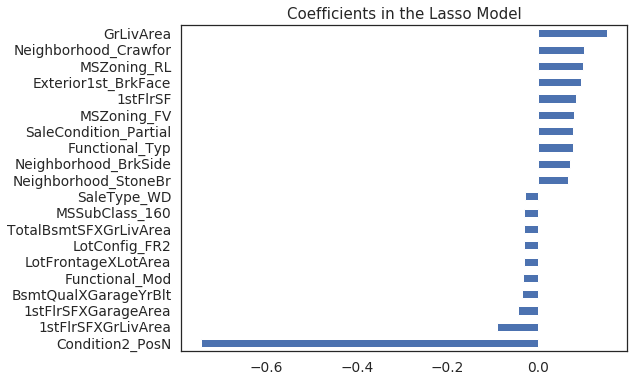

In [22]:
y_train_las = lasso.predict(X_train_preproc)
y_test_las = lasso.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train_preproc.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Lasso Model");

In [23]:
cv5_train_rmse =  cv_rmse(lasso, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(lasso, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='lasso',params=lasso.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4828672589019538, tolerance: 0.012625547164138353
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6578072034065006, tolerance: 0.013706716282636094
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4829175070200371, tolerance: 0.0132498040571775
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want t

cv5 train rmse: [0.14258791 0.14932494 0.11664587 0.11945754 0.10445874]
---------------------------------------------------------------------------
cv5 test rmse: [0.12789493 0.13615639 0.15120839 0.10987267 0.09789807]


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.300301406899139, tolerance: 0.004912019618576038
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2669928523549725, tolerance: 0.005357294318284767
  positive)


## **Linear Regression with ElasticNet Regularization (L1 and L2 penalty)**

In [24]:
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import RandomizedSearchCV

In [25]:
enet = ElasticNet(alpha=1,l1_ratio=0.5)
enet.fit(X_train_preproc,y_train)
y_pred = enet.predict(X_test_preproc)

print('R-sq:', r2_score(y_test,y_pred))
print('MSE:', mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:', r2_score(y_test_exp,y_pred_exp))
print('MSE:', mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:', np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: -0.010079098464402358
MSE: 0.15212440839267974
RMSE: 0.39003129155579264
--------------------------------------------------
R-sq: -0.007748113294549386
MSE: 5365570131.984954
RMSE: 73250.0520954419


In [26]:
enet = ElasticNet(l1_ratio=0,alpha=0.03)
enet.fit(X_train_preproc,y_train)
y_pred = enet.predict(X_test_preproc)

print('R-sq:', r2_score(y_test,y_pred))
print('MSE:', mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:', r2_score(y_test_exp,y_pred_exp))
print('MSE:', mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:', np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.9102396143270455
MSE: 0.013518491362068504
RMSE: 0.11626904730868187
--------------------------------------------------
R-sq: 0.9119961051559542
MSE: 468560608.9897412
RMSE: 21646.260854700547


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.08350855722569, tolerance: 0.01648745737340829
  positive)


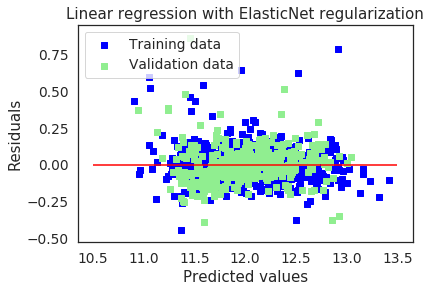

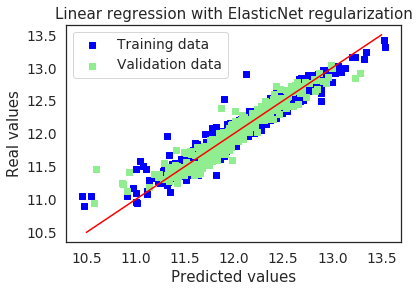

ElasticNet picked 401 features and eliminated the other 12 features


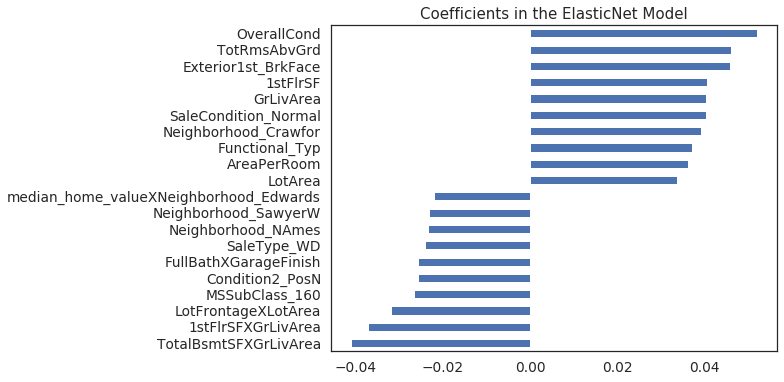

In [27]:
y_train_ela = enet.predict(X_train_preproc)
y_test_ela = enet.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(enet.coef_, index = X_train_preproc.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the ElasticNet Model");

In [28]:
cv5_train_rmse =  cv_rmse(enet, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(enet, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='enet',params=enet.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.253927107759199, tolerance: 0.012625547164138353
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.436743532933653, tolerance: 0.013706716282636094
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.798160159370879, tolerance: 0.0132498040571775
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to i

cv5 train rmse: [0.13992526 0.15573466 0.11593919 0.12326259 0.10334085]
---------------------------------------------------------------------------
cv5 test rmse: [0.12503026 0.12773416 0.14670056 0.10941863 0.1006332 ]


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2942413659947516, tolerance: 0.005357294318284767
  positive)


## **Support Vector Machine Regression**

In [29]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [30]:
svm = SVR(C=0.1, cache_size=200, coef0=1, degree=3, epsilon=0.1,
          gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
          tol=0.001, verbose=False)
svm.fit(X_train_preproc,y_train)
y_pred = svm.predict(X_test_preproc)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8979467777505936
MSE: 0.015369871609916035
RMSE: 0.12397528628688878
--------------------------------------------------
R-sq: 0.9085054049127216
MSE: 487146202.66906863
RMSE: 22071.388779799712


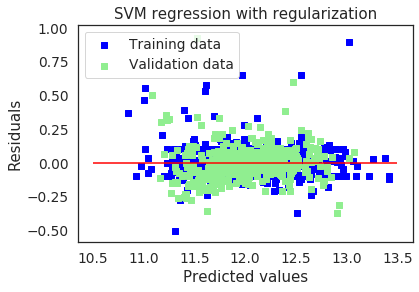

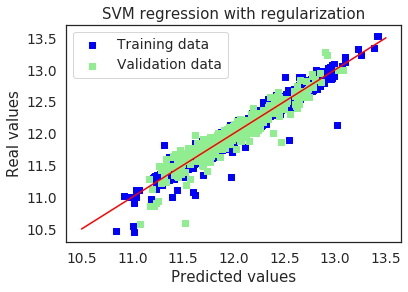

SVR picked up 382 features and eliminated 31 features


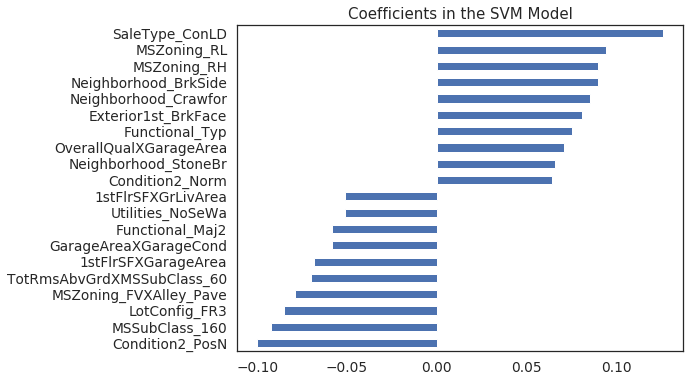

In [31]:
y_train_svm = svm.predict(X_train_preproc)
y_test_svm = svm.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_svm, y_train_svm - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_svm, y_test_svm - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("SVM regression with regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_svm, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_svm, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("SVM regression with regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(np.squeeze(svm.coef_) , index = X_train_preproc.columns)
print("SVR picked up " + str(sum(coefs != 0)) + " features and eliminated " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the SVM Model");

In [32]:
cv5_train_rmse =  cv_rmse(svm, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(svm, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='svm',params=svm.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.1531996  0.15652339 0.12884768 0.13100762 0.12501924]
---------------------------------------------------------------------------
cv5 test rmse: [0.13755186 0.14405142 0.14882672 0.12577668 0.11775489]


## **Random Forest**

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8902146659677083
MSE: 0.016534377372272393
RMSE: 0.128586069899785
--------------------------------------------------
R-sq: 0.9103830802816599
MSE: 477148864.30223966
RMSE: 21843.73741607053


In [35]:
feature_importance = pd.DataFrame(np.round(rf.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace =True)

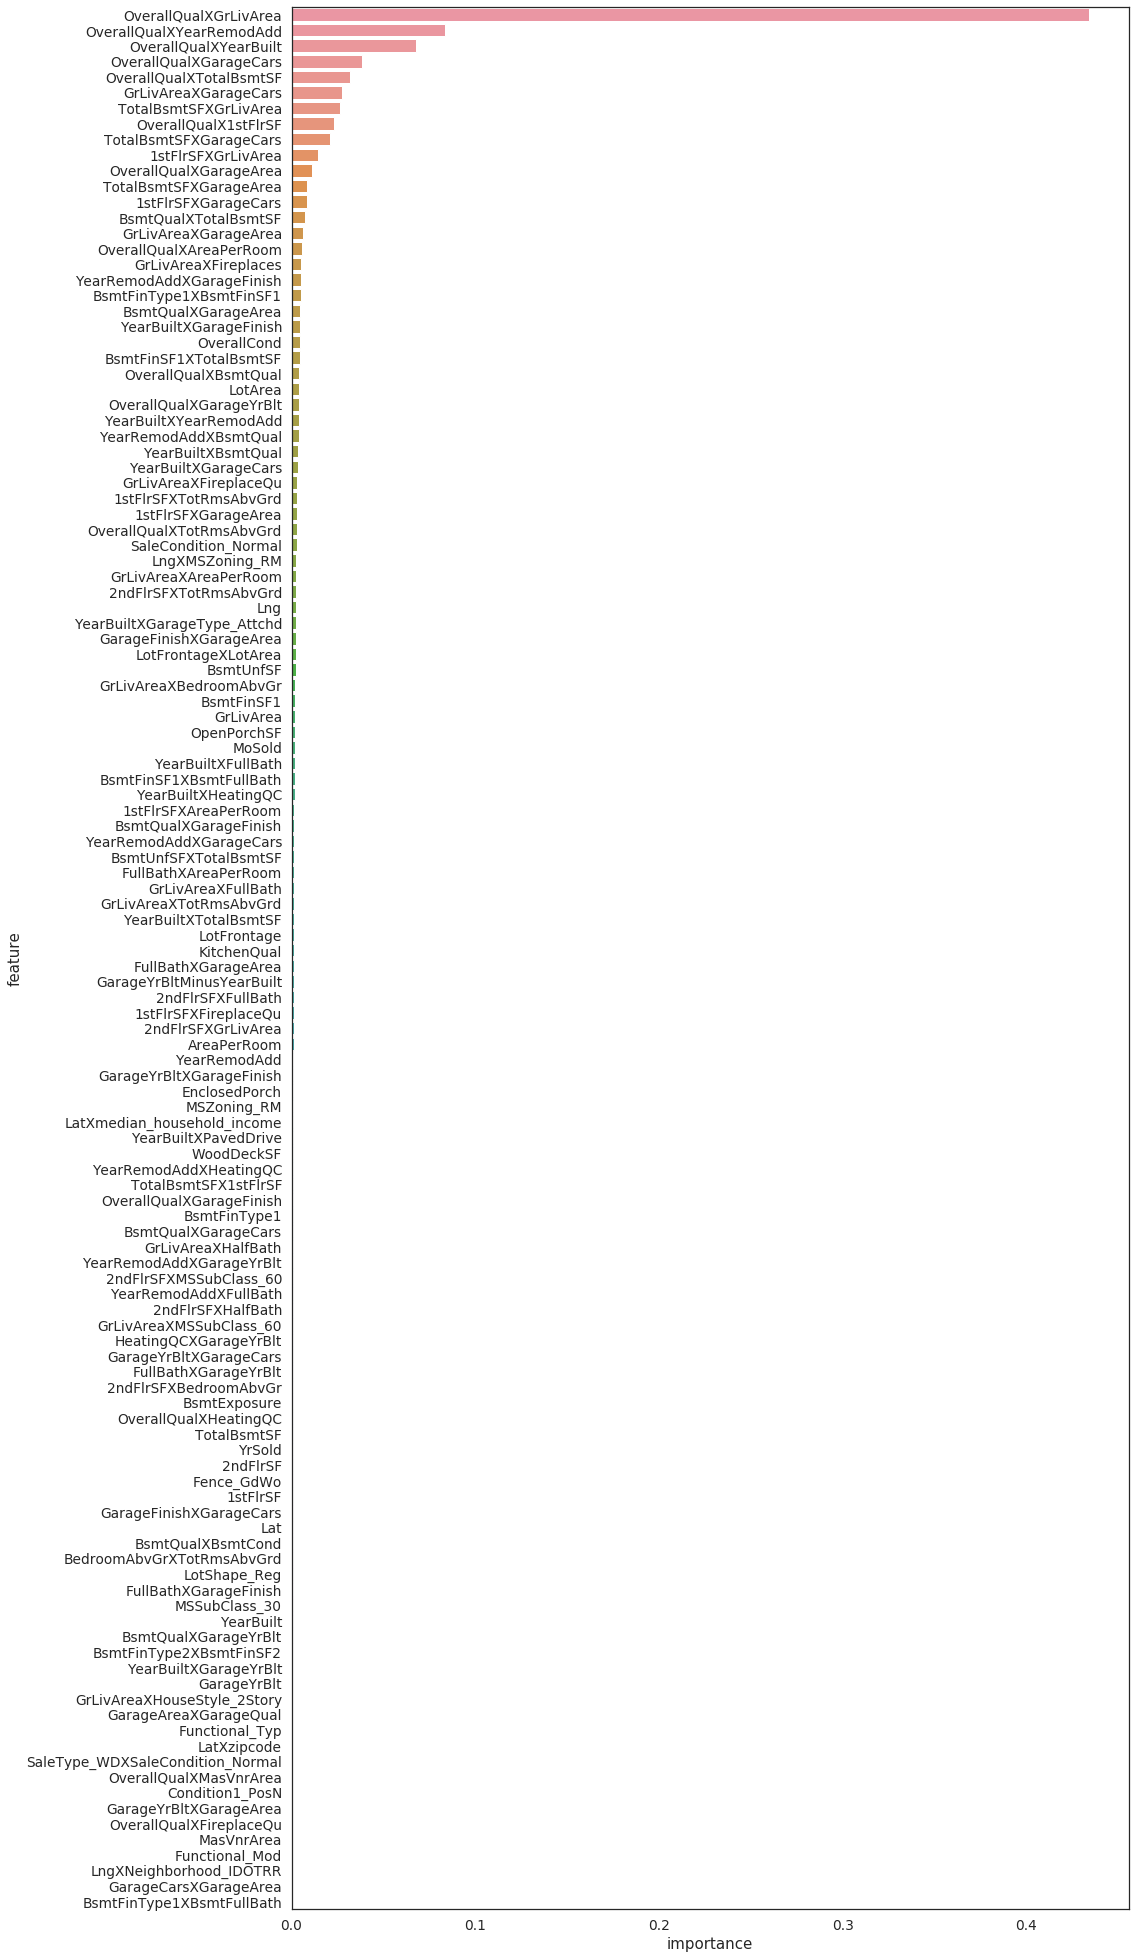

In [36]:
plt.figure(figsize=(15,35))
sns.barplot(y='feature',x='importance',data=feature_importance[feature_importance['importance']>0.0003],orient='h')

In [37]:
rf = RandomForestRegressor()
param_dist = dict(n_estimators=[100,200,300,400,500])

rf_cv = GridSearchCV(RandomForestRegressor(),param_grid=param_dist,n_jobs=5,cv=5)
rf_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=5,
             param_grid={'n_estimators': [100, 200, 300, 40

In [57]:
rf_cv.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [39]:
rf = rf_cv.best_estimator_

rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8907850577275124
MSE: 0.016448472704861515
RMSE: 0.12825159922925528
--------------------------------------------------
R-sq: 0.9120819444632344
MSE: 468103573.33051527
RMSE: 21635.70135980147


In [40]:
feature_importance = pd.DataFrame(np.round(rf.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace =True)

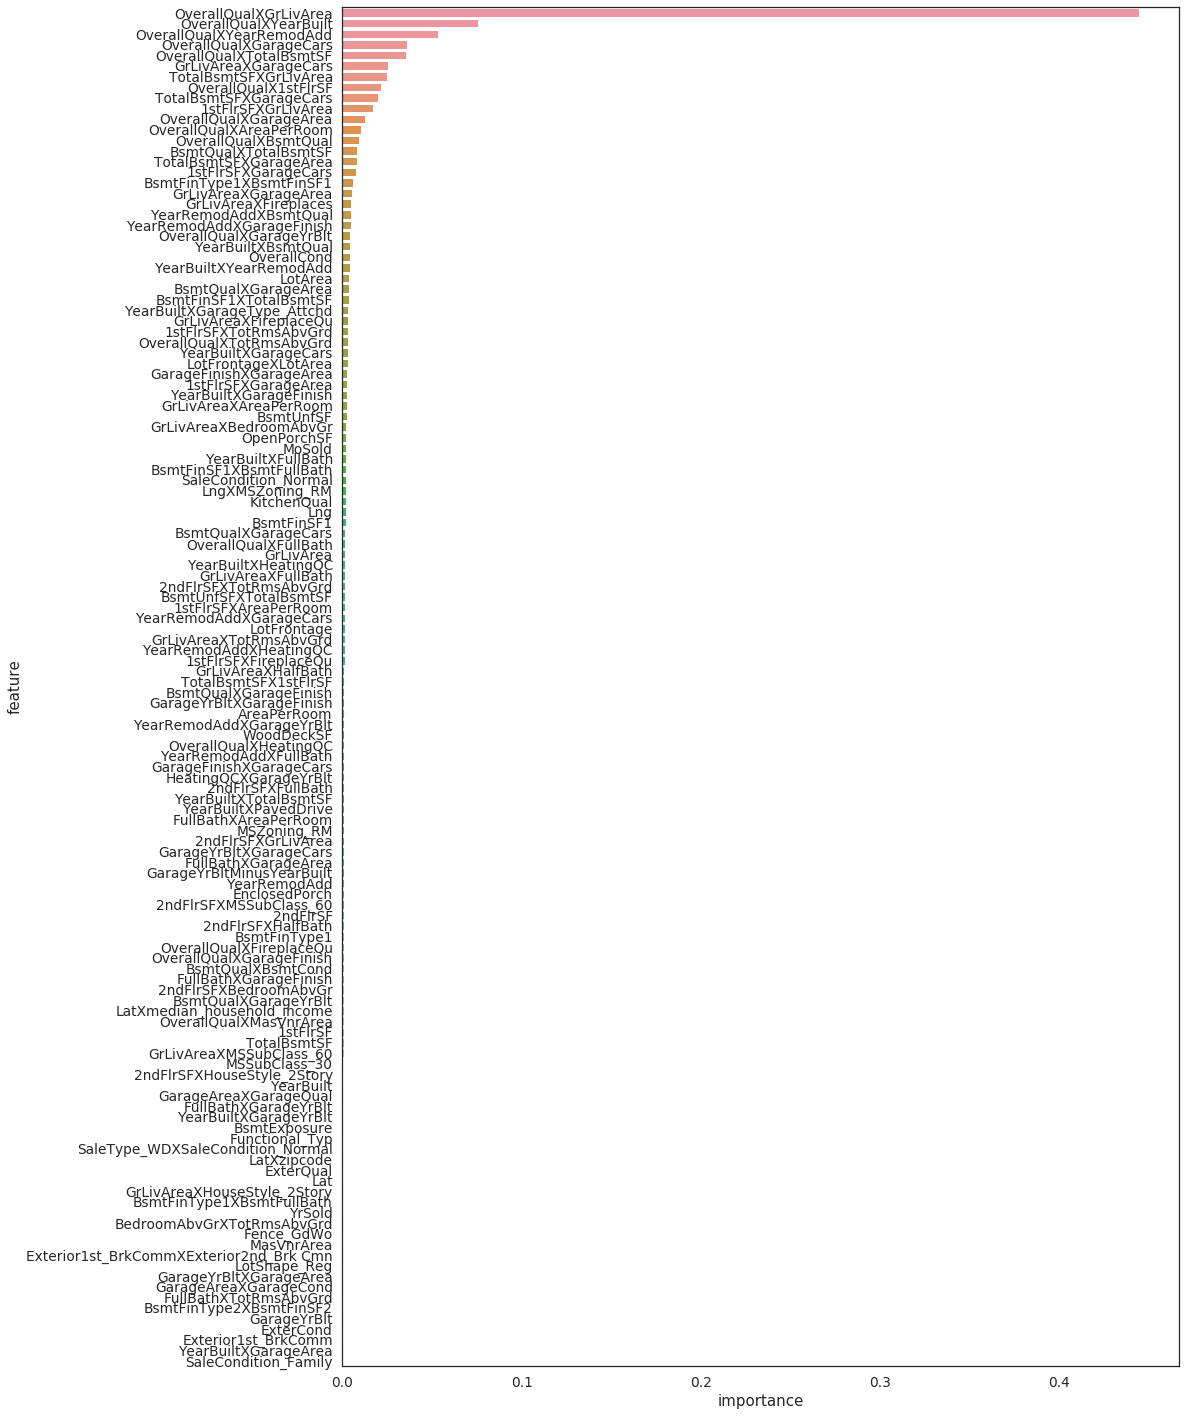

In [41]:
plt.figure(figsize=(15,25))
sns.barplot(y='feature',x='importance',data=feature_importance[feature_importance['importance']>0.0003],orient='h')

In [42]:
cv5_train_rmse =  cv_rmse(rf, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(rf, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='rf',params=rf.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.15699978 0.15158014 0.145042   0.14988199 0.12487972]
---------------------------------------------------------------------------
cv5 test rmse: [0.13407713 0.1521455  0.1740882  0.09717915 0.12624973]


## **Adaptive Boost (AdaBoost)**

In [43]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [44]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                       n_estimators=200,learning_rate=0.5,random_state=42)

ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8920183004684162
MSE: 0.016262738416675786
RMSE: 0.12752544223281795
--------------------------------------------------
R-sq: 0.9174606086018301
MSE: 439465861.9110624
RMSE: 20963.44107991487


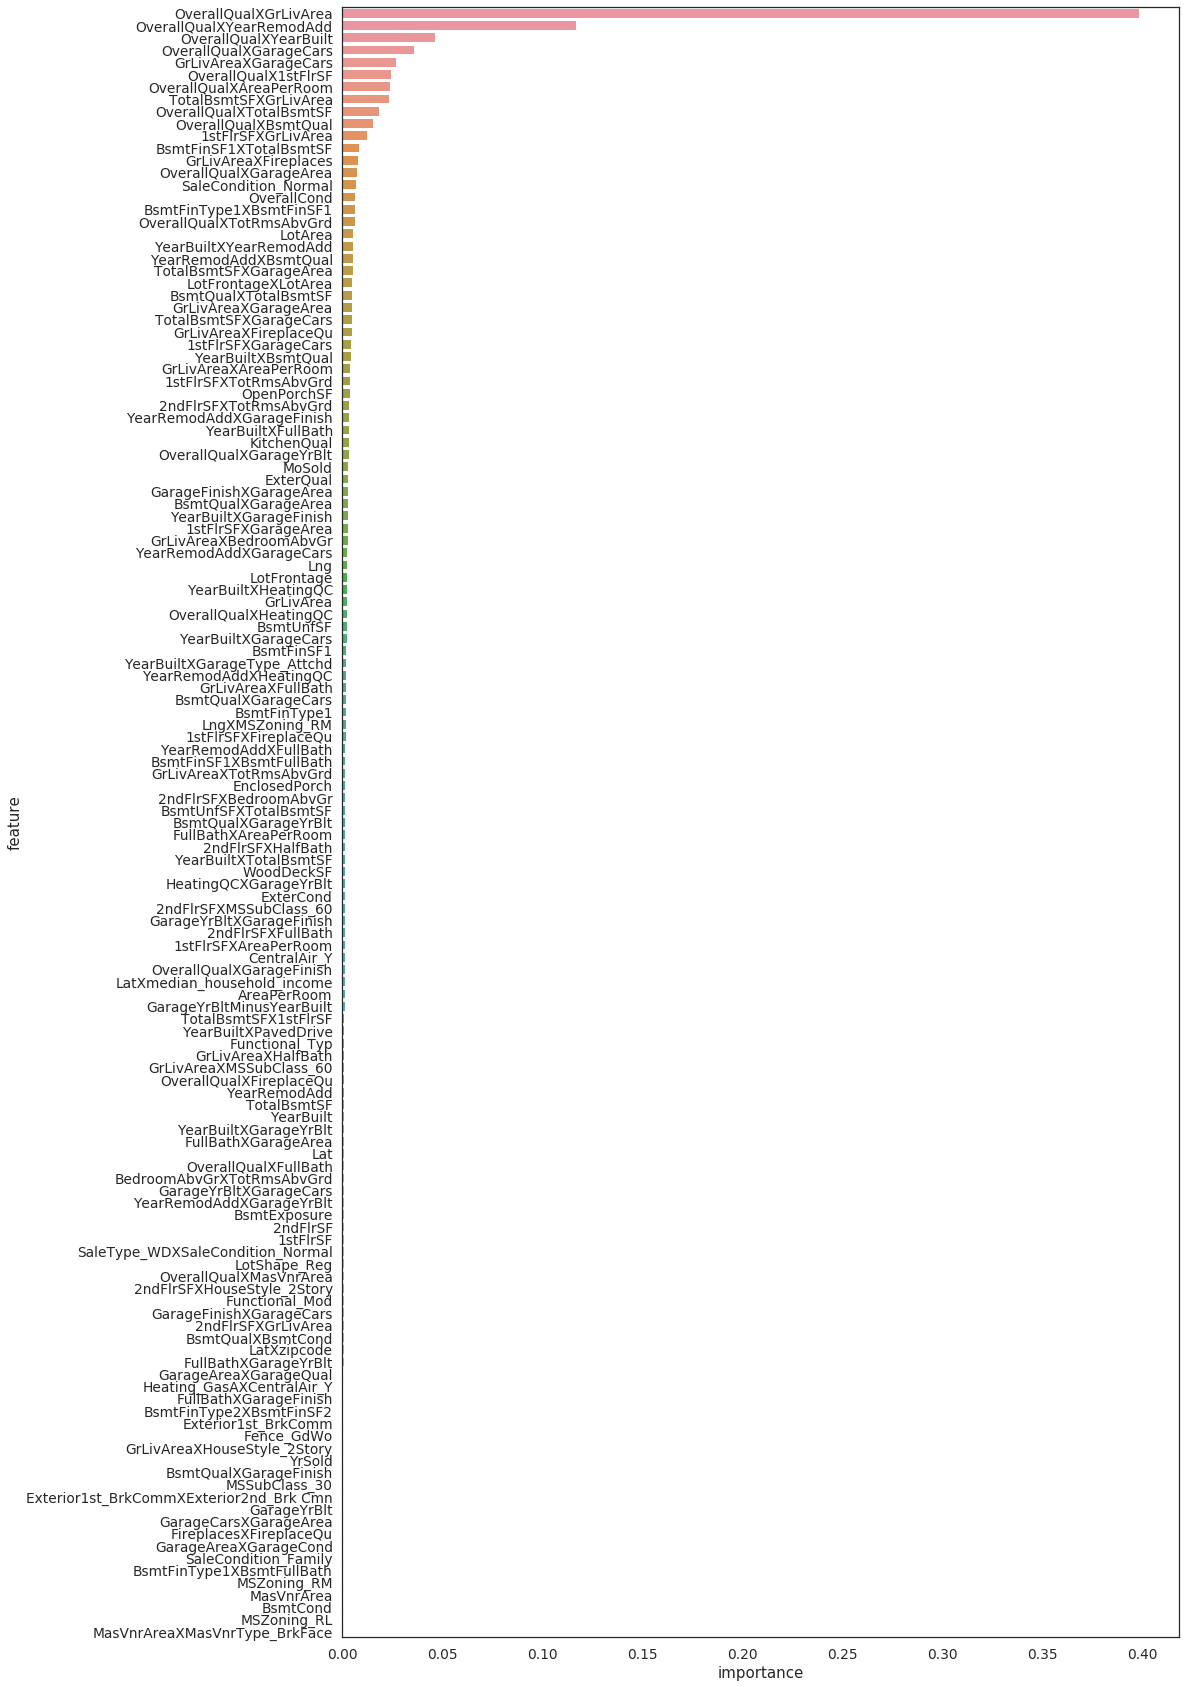

In [45]:
feature_importance = pd.DataFrame(np.round(ada.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace = True)

plt.figure(figsize=(15,30))
sns.barplot(y='feature',x='importance',data=feature_importance[feature_importance['importance']>0.0003],orient='h')

In [46]:
with open('ada_mod.pkl','rb') as mod_file:
    ada_cv = pickle.load(mod_file)

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator AdaBoostRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [47]:
ada = ada_cv.best_estimator_
ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8920460720328776
MSE: 0.01625855584045949
RMSE: 0.12750904219097361
--------------------------------------------------
R-sq: 0.9087809995270351
MSE: 485678849.65536606
RMSE: 22038.122643622937


In [48]:
cv5_train_rmse =  cv_rmse(ada, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(ada, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='ada',params=ada.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.15522463 0.15339908 0.1404703  0.14915468 0.1253269 ]
---------------------------------------------------------------------------
cv5 test rmse: [0.13725183 0.14906102 0.1722918  0.09621827 0.124811  ]


## **Gradient Boost**

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

In [50]:
gbrt = GradientBoostingRegressor()
gbrt.fit(X_train,y_train)
y_pred = gbrt.predict(X_test)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.9109801070007557
MSE: 0.013406968403046267
RMSE: 0.11578846403267584
--------------------------------------------------
R-sq orig price: 0.9171984987001361
MSE orig price: 440861418.04386306
RMSE orig price: 20996.700170356842


In [51]:
cv5_train_rmse =  cv_rmse(gbrt, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(gbrt, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='gbrt',params=gbrt.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.15158164 0.14295513 0.13814237 0.14068971 0.12012626]
---------------------------------------------------------------------------
cv5 test rmse: [0.12826166 0.15349737 0.16708302 0.10265218 0.11803086]


In [52]:
mod_table = pd.DataFrame()
for model in model_list:
    tmp_df = pd.DataFrame([model.name,
                           model.cv5_mean_train_rmse,
                           model.cv5_std_train_rmse,
                           model.cv5_mean_test_rmse,
                           model.cv5_std_test_rmse],
                          index=['model',
                                   'train_mean_rmse',
                                   'train_std_rmse',
                                   'test_mean_rmse',
                                   'test_std_rmse']).T
    
    mod_table = pd.concat([mod_table,tmp_df],axis=0)
    
mod_table.reset_index(drop=True,inplace=True)

In [53]:
for col in mod_table.columns:
    if col != 'model':
        mod_table[col]= mod_table[col].astype(float)

In [54]:
mod_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
model              8 non-null object
train_mean_rmse    8 non-null float64
train_std_rmse     8 non-null float64
test_mean_rmse     8 non-null float64
test_std_rmse      8 non-null float64
dtypes: float64(4), object(1)
memory usage: 400.0+ bytes


Text(0.5, 1.0, 'Train vs. Test RMSE')

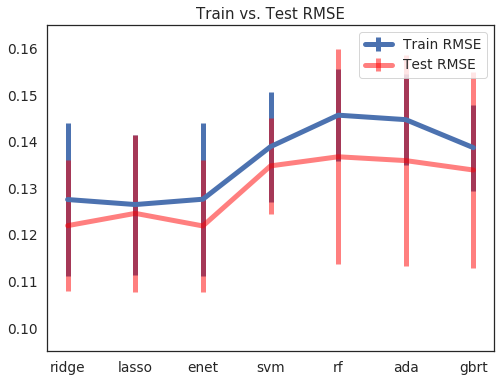

In [55]:
train_errorbar_width_array = (mod_table.loc[1:,'train_std_rmse']/np.sqrt(5))*2

plt.figure(figsize =(8,6))
plt.errorbar(x=mod_table.loc[1:,'model'],
             y=mod_table.loc[1:,'train_mean_rmse'],
             yerr=train_errorbar_width_array,
             label='Train RMSE',
             linewidth=5)

test_errorbar_width_array = (mod_table.loc[1:,'test_std_rmse']/np.sqrt(5))*2
plt.errorbar(x=mod_table.loc[1:,'model'],
             y=mod_table.loc[1:,'test_mean_rmse'],
             yerr=test_errorbar_width_array,
             label='Test RMSE',
             linewidth=5,
             color='red',
             alpha =0.5)
plt.legend()
plt.ylim(0.095,0.165)
plt.title('Train vs. Test RMSE')

In [56]:
mod_table.sort_values(by=['test_mean_rmse','test_std_rmse'],ascending=[True,True])

,model,train_mean_rmse,train_std_rmse,test_mean_rmse,test_std_rmse
3,enet,0.127641,0.018367,0.121903,0.015918
1,ridge,0.127572,0.018446,0.121965,0.015732
2,lasso,0.126495,0.016807,0.124606,0.018880
7,gbrt,0.138699,0.010328,0.133905,0.023432
4,svm,0.138920,0.013199,0.134792,0.011505
6,ada,0.144715,0.010950,0.135927,0.025286
5,rf,0.145677,0.011078,0.136748,0.025747
0,LR,1.644460,1.849830,6.919903,3.296413
